# Importing some libraries

In [1]:
import wave
import wget
from zipfile import ZipFile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.signal
%matplotlib inline

# Downloading Dataset

In [12]:
path = 'ICBHI'
if not os.path.exists(path):
    os.makedirs(path)

In [ ]:
dataset_url = 'https://bhichallenge.med.auth.gr/sites/default/files/ICBHI_final_database/ICBHI_final_database.zip'
wget.download(dataset_url, path)

In [ ]:
%cd path

In [ ]:
with ZipFile('ICBHI_final_database.zip', 'r') as zipObj:
# Extract all the contents of zip file in current directory
  zipObj.extractall(path)

In [4]:
root = 'ICBHI_final_database/audio_and_txt_files/'
filenames = [s.split('.')[0] for s in os.listdir(path = root) if '.txt' in s]

In [5]:
def Extract_Annotation_Data(file_name, root):
    tokens = file_name.split('_')
    recording_info = pd.DataFrame(data = [tokens], columns = ['Patient number', 'Recording index', 'Chest location','Acquisition mode','Recording equipment'])
    recording_annotations = pd.read_csv(os.path.join(root, file_name + '.txt'), names = ['Start', 'End', 'Crackles', 'Wheezes'], delimiter= '\t')
    return (recording_info, recording_annotations)

In [6]:
i_list = []
rec_annotations = []
rec_annotations_dict = {}
for s in filenames:
    (i,a) = Extract_Annotation_Data(s, root)
    i_list.append(i)
    rec_annotations.append(a)
    rec_annotations_dict[s] = a
recording_info = pd.concat(i_list, axis = 0)
recording_info.head()

,Patient number,Recording index,Chest location,Acquisition mode,Recording equipment
0,101,1b1,Al,sc,Meditron
0,101,1b1,Pr,sc,Meditron
0,102,1b1,Ar,sc,Meditron
0,103,2b2,Ar,mc,LittC2SE
0,104,1b1,Al,sc,Litt3200


In [7]:
no_label_list = []
crack_list = []
wheeze_list = []
both_sym_list = []
filename_list = []
for f in filenames:
    d = rec_annotations_dict[f]
    no_labels = len(d[(d['Crackles'] == 0) & (d['Wheezes'] == 0)].index)
    n_crackles = len(d[(d['Crackles'] == 1) & (d['Wheezes'] == 0)].index)
    n_wheezes = len(d[(d['Crackles'] == 0) & (d['Wheezes'] == 1)].index)
    both_sym = len(d[(d['Crackles'] == 1) & (d['Wheezes'] == 1)].index)
    no_label_list.append(no_labels)
    crack_list.append(n_crackles)
    wheeze_list.append(n_wheezes)
    both_sym_list.append(both_sym)
    filename_list.append(f)

In [8]:
file_label_df = pd.DataFrame(data = {'filename':filename_list, 'no label':no_label_list, 'crackles only':crack_list, 'wheezes only':wheeze_list, 'crackles and wheezees':both_sym_list})

# Distribution of data classes

In [9]:
w_labels = file_label_df[(file_label_df['crackles only'] != 0) | (file_label_df['wheezes only'] != 0) | (file_label_df['crackles and wheezees'] != 0)]
file_label_df.sum()

filename                 101_1b1_Al_sc_Meditron101_1b1_Pr_sc_Meditron10...
no label                                                              3642
crackles only                                                         1864
wheezes only                                                           886
crackles and wheezees                                                  506
dtype: object

In [10]:
file_label_df.iloc[919, file_label_df.columns.get_loc('filename')] = "226_1b1_Pl_sc_Meditron"

In [11]:
file_label_df.insert(1, 'id', recording_info['Patient number'].tolist())


In [12]:
file_label_df.head()

,filename,id,no label,crackles only,wheezes only,crackles and wheezees
0,101_1b1_Al_sc_Meditron,101,12,0,0,0
1,101_1b1_Pr_sc_Meditron,101,11,0,0,0
2,102_1b1_Ar_sc_Meditron,102,13,0,0,0
3,103_2b2_Ar_mc_LittC2SE,103,2,0,4,0
4,104_1b1_Al_sc_Litt3200,104,6,0,0,0


In [13]:
train_test_df = pd.read_csv('ICBHI_challenge_train_test.txt', delimiter='\t', names=['filename', 'set'])

In [14]:
file_label_df = pd.merge(file_label_df, train_test_df, left_on='filename', right_on='filename', how='right')

## SPLITING 

In [15]:
train_only = file_label_df[file_label_df['set']=='train']
train_only.head()

,filename,id,no label,crackles only,wheezes only,crackles and wheezees,set
3,103_2b2_Ar_mc_LittC2SE,103,2,0,4,0,train
10,105_1b1_Tc_sc_Meditron,105,8,0,0,0,train
11,106_2b1_Pl_mc_LittC2SE,106,1,8,0,0,train
12,106_2b1_Pr_mc_LittC2SE,106,2,0,7,0,train
13,107_2b3_Al_mc_AKGC417L,107,1,7,0,0,train


In [16]:
train_only.shape

(539, 7)

### VALIDATION

In [17]:
# Patients ID list, you can choose different ones
val_id = ['112','132','138','163','166','221']

In [18]:
val_df = train_only.loc[(train_only.id.isin(val_id))]

In [19]:
val_df.head()

,filename,id,no label,crackles only,wheezes only,crackles and wheezees,set
55,112_1b1_Ar_sc_Meditron,112,16,1,0,0,train
56,112_1b1_Lr_sc_Meditron,112,1,3,6,2,train
57,112_1p1_Ll_sc_Litt3200,112,5,0,5,0,train
58,112_1p1_Pl_sc_Litt3200,112,1,1,3,4,train
59,112_1p1_Pr_sc_Litt3200,112,1,0,8,0,train


### TRAIN

In [20]:
train_df = train_only.drop(val_df.index.values, axis=0)
train_df.head()

,filename,id,no label,crackles only,wheezes only,crackles and wheezees,set
3,103_2b2_Ar_mc_LittC2SE,103,2,0,4,0,train
10,105_1b1_Tc_sc_Meditron,105,8,0,0,0,train
11,106_2b1_Pl_mc_LittC2SE,106,1,8,0,0,train
12,106_2b1_Pr_mc_LittC2SE,106,2,0,7,0,train
13,107_2b3_Al_mc_AKGC417L,107,1,7,0,0,train


### TEST

In [21]:
test_df = file_label_df[file_label_df['set']=='test']

In [22]:
test_df.shape

(381, 7)

# Distribution of respiratory cycle lengths

longest cycle:16.163
shortest cycle:0.1999999999999993
mean cycle length:2.7005090852420994
Number of samples less than 10 seconds:6896.00
Number of samples higher than 10 seconds:2.00


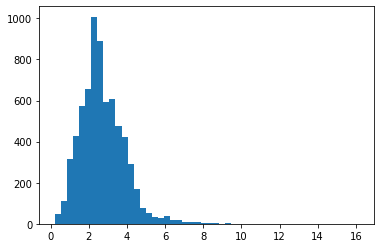

In [23]:
duration_list = []
for i in range(len(rec_annotations)):
    current = rec_annotations[i]
    duration = current['End'] - current['Start']
    duration_list.extend(duration)

duration_list = np.array(duration_list)
plt.hist(duration_list, bins = 50)
print('longest cycle:{}'.format(max(duration_list)))
print('shortest cycle:{}'.format(min(duration_list)))
print('mean cycle length:{}'.format(np.mean(duration_list)))
threshold = 10
print('Number of samples less than {} seconds:{:.2f}'.format(threshold,
                                                           np.sum(duration_list < threshold)))

print('Number of samples higher than {} seconds:{:.2f}'.format(threshold,
                                                           np.sum(duration_list > threshold)))

# Data preparation utility functions

In [24]:
#Used to split each individual sound file into separate sound clips containing one respiratory cycle each
#output: [filename, (sample_data:np.array, start:float, end:float, crackles:bool(float), wheezes:bool(float)) (...) ]
import math
import librosa

def read_wav_file(str_filename, target_rate):
    data, sample_rate = librosa.load(str_filename, sr=None)
        
    if (sample_rate != target_rate):
        data = librosa.resample(y=data, orig_sr=sample_rate, target_sr=target_rate)
    
    return (target_rate, data.astype(np.float32))

def slice_data(start, end, raw_data,  sample_rate):
    max_ind = len(raw_data) 
    start_ind = min(int(start * sample_rate), max_ind)
    end_ind = min(int(end * sample_rate), max_ind)
    return raw_data[start_ind: end_ind]

def get_sound_samples(recording_annotations, file_name, root, sample_rate):
    sample_data = [file_name]
    (rate, data) = read_wav_file(os.path.join(root, file_name + '.wav'), sample_rate)
    
    for i in range(len(recording_annotations.index)):
        row = recording_annotations.loc[i]
        start = row['Start']
        end = row['End']
        crackles = row['Crackles']
        wheezes = row['Wheezes']
        audio_chunk = slice_data(start, end, data, rate)
        sample_data.append((audio_chunk, start, end, crackles, wheezes))
    return sample_data

#Fits each respiratory cycle into a fixed length audio clip, splits may be performed and zero padding is added if necessary
#original:(arr,c,w) -> output:[(arr,c,w),(arr,c,w)]
def split_and_pad(original, desiredLength, sampleRate):
    output_buffer_length = int(desiredLength * sampleRate)
    soundclip = original[0]
    n_samples = len(soundclip)
    total_length = n_samples / sampleRate #length of cycle in seconds
    n_slices = int(math.ceil(total_length / desiredLength)) #get the minimum number of slices needed
    samples_per_slice = n_samples // n_slices
    src_start = 0 #Staring index of the samples to copy from the original buffer
    output = [] #Holds the resultant slices
    for i in range(n_slices):
        src_end = min(src_start + samples_per_slice, n_samples)
        length = src_end - src_start
        copy = generate_padded_samples(soundclip[src_start:src_end], output_buffer_length)
        output.append((copy, original[1], original[2]))
        src_start += length
    return output

def generate_padded_samples(source, output_length):
    copy = np.zeros(output_length, dtype = np.float32)
    src_length = len(source)
    if(output_length > src_length):
        #tile forward sounds to fill empty space
        cursor = 0
        while(cursor + src_length) < output_length:
            copy[cursor:(cursor + src_length)] = source[:]
            cursor += src_length
    else:
        copy[:src_length] = source[:]
    #
    return copy

In [25]:
#Takes a list of respiratory cycles, and splits and pads each cycle into fixed length buffers (determined by desiredLength(seconds))
#Then takes the split and padded sample and transforms it into a mel spectrogram

def apply_split_and_pad(original, desiredLength, sampleRate):
    output = []
    for d in original:
        
        lst_result = split_and_pad(d, desiredLength, sampleRate) #Time domain
        output.extend(lst_result)
        
    return output

# Utility used to import all samples

In [26]:
def extract_all_samples(filenames, annotation_dict, root, target_rate, desired_length):
    cycle_list = []
    for file in filenames:
        data = get_sound_samples(annotation_dict[file], file, root, target_rate)
        cycles_with_labels = [(d[0], d[3], d[4]) for d in data[1:]]
        cycle_list.extend(cycles_with_labels)
    
    #Sort into respective classes
    no_labels = [c for c in cycle_list if ((c[1] == 0) & (c[2] == 0))]
    c_only = [c for c in cycle_list if ((c[1] == 1) & (c[2] == 0))] 
    w_only = [c for c in cycle_list if ((c[1] == 0) & (c[2] == 1))]
    c_w = [c for c in cycle_list if ((c[1] == 1) & (c[2] == 1))]
    
    #Split up cycles into sound clips with fixed lengths so they can be fed into a CNN
    
    none  = (apply_split_and_pad(no_labels, desired_length, target_rate))
    
    c = (apply_split_and_pad(c_only, desired_length, target_rate))
    
    w = (apply_split_and_pad(w_only, desired_length, target_rate))
    
    c_w = (apply_split_and_pad(c_w, desired_length, target_rate)) 
    
    dict = {'none':none,'crackles':c,'wheezes':w, 'both':c_w}

    return dict
    

# Extracting Samples per set 

In [27]:
target_sample_rate = 32000
sample_length_seconds = 10
# train 
sample_dict_train = extract_all_samples(train_df.filename.tolist(), rec_annotations_dict, root, target_sample_rate, sample_length_seconds) 

In [28]:
# test
sample_dict_test = extract_all_samples(test_df.filename.tolist(), rec_annotations_dict, root, target_sample_rate, sample_length_seconds) 

In [29]:
# validation
sample_dict_val = extract_all_samples(val_df.filename.tolist(), rec_annotations_dict, root, target_sample_rate, sample_length_seconds) 

In [30]:
def print_sample_count(src_dict):
    print('none:{}\ncrackles:{}\nwheezes:{}\nboth:{}'.format(len(src_dict['none']),
                                                        len(src_dict['crackles']),
                                                        len(src_dict['wheezes']),
                                                        len(src_dict['both'])))

print('Samples Available')
print('[Training set]')
print_sample_count(sample_dict_train)

Samples Available
[Training set]
none:1850
crackles:1058
wheezes:443
both:318


In [31]:
print('Samples Available')
print('[Testing set]')
print_sample_count(sample_dict_test)

Samples Available
[Testing set]
none:1579
crackles:649
wheezes:385
both:143


In [32]:
print('Samples Available')
print('[Validation set]')
print_sample_count(sample_dict_val)

Samples Available
[Validation set]
none:215
crackles:157
wheezes:58
both:45


## Saving wav files

In [33]:
# Saving Train samples
import soundfile as sf

dir = 'Train'
os.makedirs(dir, exist_ok=True)
train_list = []

for sample in ['none', 'crackle', 'wheezes', 'both']:
    # Saving Normal Samples
    for i, file in enumerate(sample_dict_train[sample]):
        name = sample+"_"+str(i)+".wav"
        x = file[0]
        path = os.path.join(dir, name)
        sf.write(path, x, target_sample_rate)
        
        train_dict = {'filename':name, 'id':0}
        
        train_list.append(train_dict)

In [ ]:
# Creating dataframe for train samples and save It
train_samples = pd.DataFrame(train_list, columns = train_dict.keys())
train_samples.to_csv(dir+'.csv', index=False)

In [ ]:
# Saving Test samples
import soundfile as sf

test_dir = 'Test'
os.makedirs(test_dir, exist_ok=True)
test_list = []

for sample in ['none', 'crackle', 'wheezes', 'both']:
    for i, file in enumerate(sample_dict_test[sample]):
        name = sample+"_"+str(i)+".wav"
        x = file[0]
        path = os.path.join(test_dir, name)
        sf.write(path, x, target_sample_rate)
        
        test_dict = {'filename':name, 'id':0}
        
        test_list.append(test_dict)

In [ ]:
# Creating dataframe for Test samples and save It 
test_samples = pd.DataFrame(test_list, columns = test_dict.keys())
test_samples.to_csv(test_dir+'.csv', index=False)

In [ ]:
# Saving Validation samples
import soundfile as sf

val_dir = 'Val'
os.makedirs(val_dir, exist_ok=True)
val_list = []

# Saving Normal Samples
for sample in ['none', 'crackle', 'wheezes', 'both']:
    for i, file in enumerate(sample_dict_val[sample]):
        name = sample+"_"+str(i)+".wav"
        x = file[0]
        path = os.path.join(val_dir, name)
        sf.write(path, x, target_sample_rate)
        
        val_dict = {'filename':name, 'id':0}
        
        val_list.append(val_dict)

In [ ]:
# Creating dataframe for validation samples nd save It 
val_samples = pd.DataFrame(val_list, columns = val_dict.keys())
val_samples.to_csv(val_dir+'.csv', index=False)